# Train Domain classifier from the [semantic scholar dataset](https://api.semanticscholar.org/corpus)

## Download dataset (or a part of it)

```sh
wget https://s3-us-west-2.amazonaws.com/ai2-s2-research-public/open-corpus/2022-02-01/manifest.txt
wget -B https://s3-us-west-2.amazonaws.com/ai2-s2-research-public/open-corpus/2022-02-01/ -i manifest.txt
```

In [7]:
import json
import matplotlib.pyplot as plt
from sklearn import metrics
from pathlib import Path
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import train_test_split
from pathlib import Path
import pandas as pd
from joblib import dump
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from random import shuffle, seed
from sklearn.model_selection import GridSearchCV
from pprint import pprint
import re
from sus.parallel_map import parallel_map
from config import model_key
from sus.clean import clean
from sus.language import is_english, predict_language
from sus.lemmatize_text import lemmatize_text

## Configuration

In [8]:
SS_CORPUS_PATH = Path("./data")
PREFIX = "domain-"
SEED = 42
HYPERPARAMETER_OPTIMISATION_SIZE = 1000000
MAX_FILE_COUNT = 5

# LargeFile.configure_credentials_from_file("../../../secrets/s3.ini")
plt.rcParams["figure.figsize"] = (30, 15)
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = 12
plt.rcParams["axes.xmargin"] = 0
seed(SEED)

## Preprocessing

In [12]:
def preprocess(text: str) -> str:
    cleaned = clean(text, convert_to_ascii=True)
    lemmas = [
        re.sub(r'\d+', 'NUM', lemma)
        for lemma in lemmatize_text(cleaned)
    ]
    return " ".join(lemmas)

In [13]:
def clean_file(p: Path):
    try:
        processed_path = p.with_name(f"{PREFIX}{p.stem}{p.suffix}")

        if processed_path.exists():
            return

        with open(p) as f:
            content = json.load(f)

        result = {
            preprocess(f'{c["title"]} {c["abstract"]}'): c["domain"]
            for c in content
            if (
                c["domain"]
                and c["abstract"]
                and is_english(predict_language(c["abstract"]))
            )
        }

        with open(processed_path, "w") as f:
            json.dump(result, f)
    except Exception as e:
        print(f"Error ({e}) processing {p}")


parallel_map(
    clean_file,
    list(SS_CORPUS_PATH.glob("s2-corpus-*.json"))[:MAX_FILE_COUNT],
    chunk_size=1,
)
None

100%|██████████| 5/5 [00:00<00:00, 56679.78it/s]


In [14]:
corpora = list(SS_CORPUS_PATH.glob(f"{PREFIX}*.json"))
shuffle(corpora)
print(f'Found {len(corpora)} files')

data = []
for p in corpora[:MAX_FILE_COUNT]:
    with open(p) as f:
        data.extend(json.load(f).items())

print(f'Found {len(data)} documents')

Found 5 files
Found 77176 documents


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    [d[0] for d in data],
    [d[1] for d in data],
    test_size=0.1, 
    random_state=SEED
)

X_train = [
    x
    for x, y in zip(X_train, y_train)
    for domain in y
]

y_train = [
    domain
    for x, y in zip(X_train, y_train)
    for domain in y
]

## Naive Bayes

In [ ]:
classifier = GridSearchCV(
    Pipeline(steps=[
        ('vectorizer', TfidfVectorizer()),
        ('classifier', ComplementNB())
    ]),
    {
        "vectorizer__max_df": [0.05, 0.1, 0.3],
        "vectorizer__min_df": [5, 10, 30, 100],
        "vectorizer__sublinear_tf": [True, False],
        "classifier__alpha": [0.001, 0.1, 0.5, 1],
        "classifier__fit_prior": [True, False]
    },
    scoring="f1_macro",
        cv=3,
        n_jobs=12,
        verbose=7,
)
classifier.fit(X_train[:HYPERPARAMETER_OPTIMISATION_SIZE], y_train[:HYPERPARAMETER_OPTIMISATION_SIZE])

results = pd.DataFrame(classifier.cv_results_)
results.sort_values("rank_test_score")

In [17]:
classifier = Pipeline(steps=[
    ('vectorizer', TfidfVectorizer(min_df=10, max_df=0.05)),
    ('classifier', ComplementNB(alpha=0.5, fit_prior=False))
])

classifier.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_df=0.05, min_df=10)),
                ('classifier', ComplementNB(alpha=0.5, fit_prior=False))])

                       precision    recall  f1-score   support

                  Art       0.41      0.43      0.42        67
              Biology       0.76      0.73      0.75       579
             Business       0.55      0.65      0.60       195
            Chemistry       0.77      0.71      0.74       674
     Computer Science       0.64      0.85      0.73       804
            Economics       0.69      0.53      0.60       173
          Engineering       0.62      0.31      0.42       537
Environmental Science       0.59      0.31      0.41       156
            Geography       0.61      0.30      0.40       152
              Geology       0.66      0.64      0.65       134
              History       0.36      0.15      0.21        62
    Materials Science       0.63      0.85      0.72       615
          Mathematics       0.86      0.67      0.75       307
             Medicine       0.88      0.92      0.90      2138
           Philosophy       0.60      0.29      0.39  

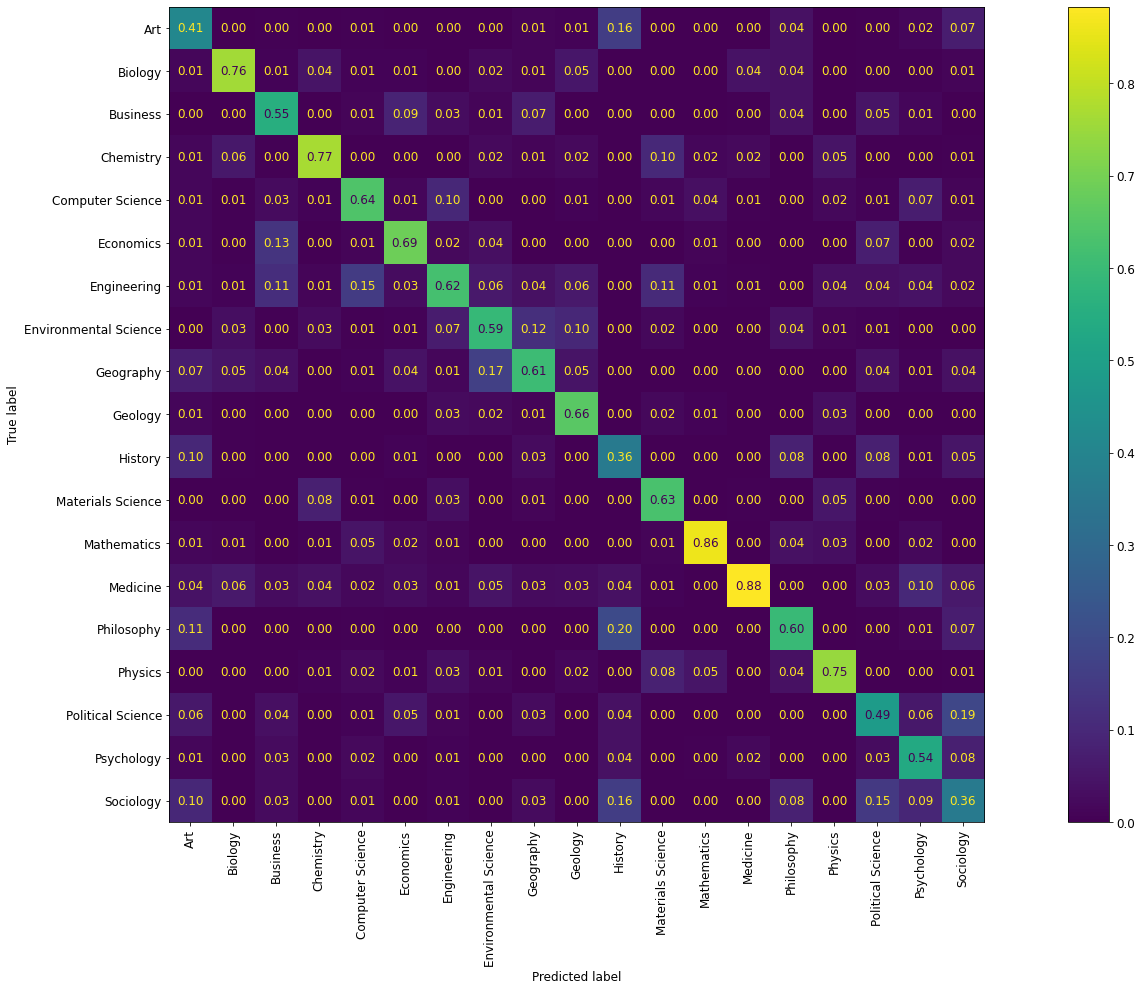

In [18]:
predicted = classifier.predict(X_test)

y_test_aligned = [p if p in y else y[0] for p, y in zip(predicted, y_test)]

print(metrics.classification_report(y_test_aligned, predicted))
metrics.ConfusionMatrixDisplay.from_predictions(
    y_true=y_test_aligned, y_pred=predicted, xticks_rotation="vertical", normalize="pred", values_format='.2f'
)
None

In [ ]:
path = model_key
dump(p, path)
# LargeFile(path, "w", keep_last_n=1).push(path)

In [ ]:
for X, y in zip(X_test[:50], y_test):
    print(', '.join(y))
    pprint(predict(X))
    print()